<a href="https://colab.research.google.com/github/alexndremelyanov/_/blob/main/L5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import time
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [100]:
data = pd.read_csv('video_games.csv')

In [101]:
data

,id,platform,year,genre,publisher,na_sales,eu_sales,other_sales,jp_sales
0,2830,PSV,2012,Racing,Electronic Arts,0.38,0.52,0.25,1.01
1,3865,SNES,1996,Role-Playing,ASCII Entertainment,0.00,0.00,0.00,1.31
2,4617,PSP,2009,Sports,Takara Tomy,0.09,0.00,0.01,1.04
3,3675,DS,2007,Fighting,Takara Tomy,0.00,0.00,0.00,1.08
4,1612,PSV,2016,Action,Namco Bandai Games,0.00,0.00,0.00,1.12
...,...,...,...,...,...,...,...,...,...
4253,3996,PSP,2010,Adventure,Tecmo Koei,0.00,0.00,0.00,1.09
4254,5720,Wii,2007,Shooter,Nintendo,3.06,1.18,0.46,1.29
4255,4579,3DS,2015,Action,FuRyu,0.00,0.00,0.00,1.06
4256,4072,GB,1996,Role-Playing,ChunSoft,0.00,0.00,0.00,1.27


In [102]:
numeric_features = ['na_sales','eu_sales','other_sales']
categorical_features = ['platform','genre','year','publisher']

encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(data[categorical_features])

x = np.hstack((data[numeric_features].values, encoded_features))
y = data["jp_sales"]

In [103]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=100)

### Линейный градиентный спуск

In [104]:
class LinearRegressionGD:
    def __init__(self, lr=0.01, max_iter=1000, tol=1e-3, intercept = True):
        self.learning_rate = lr
        self.max_iteration = max_iter
        self.tolerance_convergence  = tol
        self.intercept = intercept
        self.theta = None
        self.n = None
        self.d = None

    def fit(self, X, y, x_, y_):
        self.X = X.copy()
        if self.intercept:
            self.X = np.hstack((np.ones((self.X.shape[0], 1)), self.X))
        self.n, self.d = self.X.shape
        self.theta = np.random.randn(self.d)
        steps, errors, errors_ = [], [], []
        step = 0
        for _ in range(self.max_iteration):
            grad = self.gradient(self.X, y)
            self.theta -= self.learning_rate * grad
            new_error = ((y - self.predict(X)).T @ (y - self.predict(X))) / self.n
            new_error_ = self.MSE(x_, y_)
            step += 1
            steps.append(step)
            errors.append(new_error)
            errors_.append(new_error_)
            if np.linalg.norm(grad) < self.tolerance_convergence:
                break
        return steps, errors, errors_

    def gradient(self, X, y):
        return X.T @ (X @ self.theta - y) / len(y)

    def predict(self, X):
        if self.intercept:
            X_ = np.hstack((np.ones((X.shape[0],1)), X))
        else:
            X_ = X
        return X_ @ self.theta

    def MSE(self, X, y):
        return ((y - self.predict(X)).T @ (y - self.predict(X))) / len(y)

    def MAE(self, X, y):
        return abs(y - self.predict(X)).mean()

    def MAPE(self, X, y):
        return abs((y - self.predict(X))/y).mean()

In [105]:
LEARNING_RATE = 0.01
MAX_ITERATIONS = 2000
TOLERANCE_CONVERGENCE = 1e-3

Время обучения: 29.807475566864014; MSE_TRAIN: 0.74169540701872; MSE_TEST: 0.8533762640412836


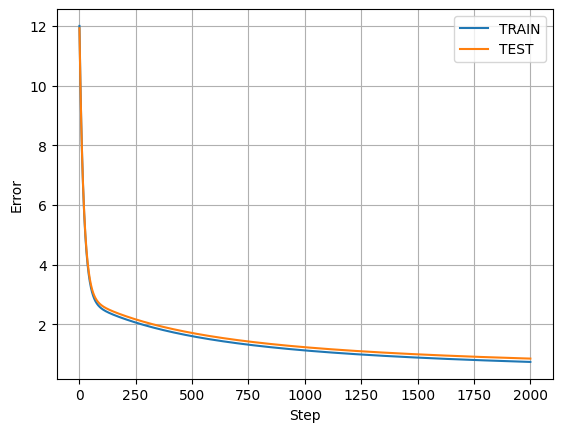

In [106]:
start_time = time.time()

modelGD = LinearRegressionGD(lr=LEARNING_RATE, max_iter=MAX_ITERATIONS, tol=TOLERANCE_CONVERGENCE)
GD_STEPS, GD_ERRORS_TRAIN, GD_ERRORS_TEST = modelGD.fit(x_train, y_train, x_test, y_test)

GD_STUDY_TIME = time.time() - start_time

GD_MSE_TRAIN = modelGD.MSE(x_train, y_train)
GD_MSE_TEST = modelGD.MSE(x_test, y_test)

print(f'Время обучения: {GD_STUDY_TIME}; MSE_TRAIN: {GD_MSE_TRAIN}; MSE_TEST: {GD_MSE_TEST}')

plt.ylabel('Error')
plt.xlabel('Step')
plt.plot(GD_STEPS, GD_ERRORS_TRAIN, label = "TRAIN")
plt.plot(GD_STEPS, GD_ERRORS_TEST, label = "TEST")
plt.legend()
plt.grid()

### Стохастический градиентный спуск

In [107]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [108]:
class LinearRegressionSGD:
    def __init__(self, lr=LEARNING_RATE, max_iter=MAX_ITERATIONS, batch_size=8, tol=TOLERANCE_CONVERGENCE, intercept = True):
        self.learning_rate = lr
        self.max_iteration = max_iter
        self.batch_size = batch_size
        self.tolerance_convergence  = tol
        self.intercept = intercept
        self.theta = None
        self.n = None
        self.d = None

    def fit(self, X, y, x_, y_):
        self.X = X.copy()
        self.y = y.copy()
        if self.intercept:
            self.X = np.hstack((np.ones((self.X.shape[0], 1)), self.X))
        self.n, self.d = self.X.shape
        self.theta = np.random.randn(self.d)
        steps, errors, errors_ = [], [], []
        step = 0
        for _ in range(self.max_iteration):
            indices = np.random.permutation(self.n)
            X = self.X[indices]
            y = self.y[indices]
            for i in range(0, self.n, self.batch_size):
                X_batch = X[i:i+self.batch_size]
                y_batch = y[i:i+self.batch_size]
                grad = self.gradient(X_batch, y_batch)
                self.theta -= self.learning_rate * grad
            new_error = ((self.y - self.X @ self.theta).T @ (self.y - self.X @ self.theta)) / self.n
            new_error_ = self.MSE(x_, y_)
            step += 1
            steps.append(step)
            errors.append(new_error)
            errors_.append(new_error_)
            if np.linalg.norm(grad) < self.tolerance_convergence:
                break
        return steps, errors, errors_

    def gradient(self, X, y):
        return X.T @ (X @ self.theta - y) / len(y)

    def predict(self, X):
        if self.intercept:
            X_ = np.hstack((np.ones((X.shape[0],1)), X))
        else:
            X_ = X
        return X_ @ self.theta

    def MSE(self, X, y):
        return ((y - self.predict(X)).T @ (y - self.predict(X))) / len(y)

    def MAE(self, X, y):
        return abs(y - self.predict(X)).mean()

    def MAPE(self, X, y):
        return abs((y - self.predict(X))/y).mean()

Время обучения: 68.5070309638977; MSE_TRAIN: 0.1295159924068497; MSE_TEST: 0.25033741423653844


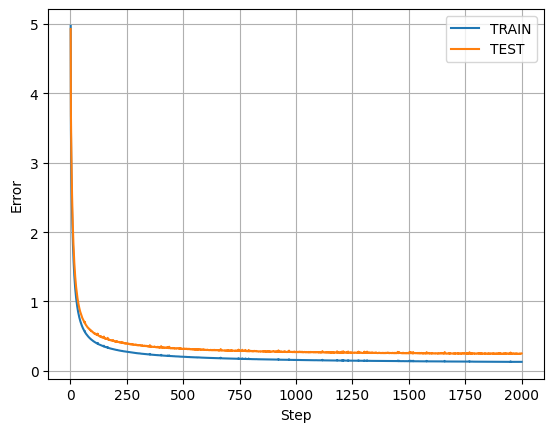

In [109]:
start_time = time.time()
modelSGD = LinearRegressionSGD(lr=LEARNING_RATE, max_iter = MAX_ITERATIONS, batch_size=64, tol=TOLERANCE_CONVERGENCE, intercept = True)
SGD_STEPS,SGD_ERRORS_TRAIN, SGD_ERRORS_TEST = modelSGD.fit(x_train, y_train, x_test, y_test)

SGD_STUDY_TIME = time.time() - start_time

SGD_MSE_TRAIN = modelSGD.MSE(x_train, y_train)
SGD_MSE_TEST = modelSGD.MSE(x_test, y_test)

print(f'Время обучения: {SGD_STUDY_TIME}; MSE_TRAIN: {SGD_MSE_TRAIN}; MSE_TEST: {SGD_MSE_TEST}')
plt.ylabel('Error')
plt.xlabel('Step')
plt.plot(SGD_STEPS, SGD_ERRORS_TRAIN, label = "TRAIN")
plt.plot(SGD_STEPS, SGD_ERRORS_TEST, label = "TEST")
plt.legend()
plt.grid()

### ADAM

In [110]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [111]:
class ADAM:
  def __init__(self, lr=LEARNING_RATE, max_iter=MAX_ITERATIONS, tol=TOLERANCE_CONVERGENCE, intercept = True, beta1=0.9, beta2=0.999, epsylon = 1e-8):
    self.learning_rate = lr
    self.max_iteration = max_iter
    self.tolerance_convergence  = tol
    self.intercept = intercept
    self.theta = None
    self.n = None
    self.d = None
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsylon = epsylon
    self.s = None
    self.v = None

  def fit(self, X, y, x_, y_):
        self.X = X.copy()
        if self.intercept:
            self.X = np.hstack((np.ones((self.X.shape[0], 1)), self.X))
        self.n, self.d = self.X.shape
        self.theta = np.random.randn(self.d)
        self.s = np.zeros(self.d)
        self.v = np.zeros(self.d)
        steps, errors, errors_ = [], [], []
        step = 0
        for _ in range(self.max_iteration):
            grad = self.gradient(self.X, y)
            self.s = self.beta1*self.s + (1 - self.beta1)*grad
            self.v = self.beta2*self.v + (1-self.beta2)*(grad**2)
            s_hat = self.s / (1-self.beta1**(_ + 1))
            v_hat = self.v / (1-self.beta2**(_ + 1))
            self.theta -= self.learning_rate * s_hat / (np.sqrt(v_hat) + self.epsylon)
            new_error = ((y - self.predict(X)).T @ (y - self.predict(X))) / self.n
            new_error_ = self.MSE(x_, y_)
            step += 1
            steps.append(step)
            errors.append(new_error)
            errors_.append(new_error_)
            if np.linalg.norm(grad) < self.tolerance_convergence:
                break
        return steps, errors, errors_


  def gradient(self, X, y):
       return X.T @ (X @ self.theta - y) / len(y)

  def predict(self, X):
      if self.intercept:
          X_ = np.hstack((np.ones((X.shape[0],1)), X))
      else:
           X_ = X
      return X_ @ self.theta

  def MSE(self, X, y):
      return ((y - self.predict(X)).T @ (y - self.predict(X))) / len(y)

Время обучения: 8.4196457862854; MSE_TRAIN: 0.1295159924068497; MSE_TEST: 0.25033741423653844


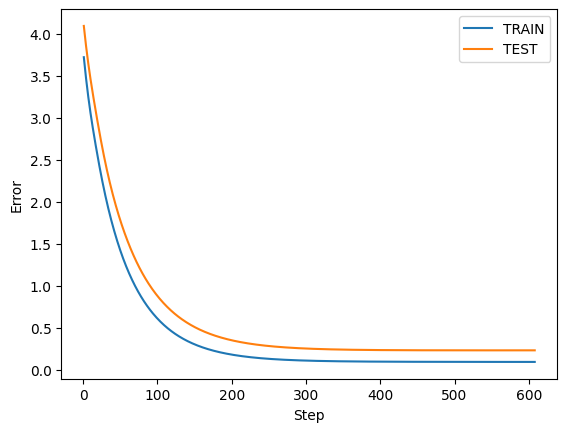

In [112]:
start_time = time.time()
modelADAM = ADAM(lr=LEARNING_RATE, max_iter=MAX_ITERATIONS, tol=TOLERANCE_CONVERGENCE, intercept = True, beta1=0.9, beta2=0.999, epsylon = 1e-8)
ADAM_STEPS,ADAM_ERRORS_TRAIN, ADAM_ERRORS_TEST = modelADAM.fit(x_train, y_train, x_test, y_test)

ADAM_STUDY_TIME = time.time() - start_time

ADAM_MSE_TRAIN = modelADAM.MSE(x_train, y_train)
ADAM_MSE_TEST = modelADAM.MSE(x_test, y_test)

print(f'Время обучения: {ADAM_STUDY_TIME}; MSE_TRAIN: {SGD_MSE_TRAIN}; MSE_TEST: {SGD_MSE_TEST}')
plt.plot(ADAM_STEPS, ADAM_ERRORS_TRAIN, label = 'TRAIN')
plt.plot(ADAM_STEPS, ADAM_ERRORS_TEST, label = 'TEST')
plt.ylabel('Error')
plt.xlabel('Step')
plt.grid()
plt.legend()
plt.grid()

### Сравнение результатов

In [120]:
df = pd.DataFrame({
    'METHOD': ['GD', 'SGD', 'ADAM'],
    'STUDY_TIME': [GD_STUDY_TIME, SGD_STUDY_TIME, ADAM_STUDY_TIME],
    'MSE_TRAIN': [GD_MSE_TRAIN, SGD_MSE_TRAIN, ADAM_MSE_TRAIN],
    'MSE_TEST': [GD_MSE_TEST, SGD_MSE_TEST, ADAM_MSE_TEST]
})
print(df.to_string(index=False))

METHOD  STUDY_TIME  MSE_TRAIN  MSE_TEST
    GD   29.807476   0.741695  0.853376
   SGD   68.507031   0.129516  0.250337
  ADAM    8.419646   0.097460  0.235183
